# 『正多面体と素数』の計算をしましょう(6)の計算ノート

In [1]:
from IPython.display import display, Math
import numpy as np

In [2]:
var('x y X')

(x, y, X)

In [3]:
#ヘッシアンの行列式を計算
def det_hessian(f):
    return det(f.hessian()).expand().simplify_full()

#二つの関数からヤコビアンを計算
def det_jacobian(f,g):
    return det(jacobian([f,g],[x,y])).expand().simplify_full()

#有理数の分子と分母を素因数分解してlatex形式で返す関数
def get_factorized_rational(numerator, denominator):
    factors_a = list(factor(numerator))
    factors_b = list(factor(denominator))
    num = ""
    if(len(factors_a)==0):
        num = "1"
    else:
        for i, t in enumerate(factors_a):
            p, k = t
            if(k==1):
                num += f"{p}"
            else:
                num += f"{p}^{{{k}}}"
            if(i<len(factors_a)-1):
                num += r" \!\cdot\! "
                
    den = ""
    if(len(factors_b)==0):
        den = "1"
    else:
        for i, t in enumerate(factors_b):
            p, k = t
            if(k==1):
                den += f"{p}"
            else:
                den += f"{p}^{{{k}}}"
            if(i<len(factors_b)-1):
                den += r" \!\cdot\! "
    return "\\frac{{{0}}}{{{1}}}".format(num, den)

# 整数の平方根をいい感じにlatex形式で返す関数
def format_factors(squared_factors):
    if(len(squared_factors)==0):
        return '1'
    integer_parts = []
    sqrt_parts = []
    for i, t in enumerate(squared_factors):
        p,k = t
        if(k%2==0):
            if(k//2==1):
                integer_parts.append(f'{p}')
            else:
                integer_parts.append(f'{p}^{k//2}')
        else:
            if(k//2==1):
                integer_parts.append(f'{p}')
            elif(k//2>1):
                integer_parts.append(f'{p}^{k//2}')
            sqrt_parts.append(f'{p}')
    integer_part = ' \\!\\cdot\\! '.join(integer_parts)
    if(len(sqrt_parts)==0):
        sqrt_part = ''
    else:
        sqrt_part_inner = ' \\!\\cdot\\! '.join(sqrt_parts)
        sqrt_part = f'\\sqrt{{{sqrt_part_inner}}}'
    return f'{integer_part}{sqrt_part}'

#x,yの同次（deg次）多項式fをいい感じに表示する
def get_latex_polynomial(f, deg, xy=True):
    lines = ""
    for i in reversed(range(deg+1)):
        j = deg-i
        if(i<j):break
        if(xy):
            c=f.coefficient(x^i*y^j)
        else:
            c=f.coefficient(X^i)
        p = numerator(c*c).pyobject()
        q = denominator(c*c).pyobject()
        if(p>0):
            if(xy):
                sgn1 = '+' if f.coefficient(x^i*y^j)/f.coefficient(x^j*y^i) == 1 else '-'
            else:
                sgn1 = '+' if f.coefficient(X^i)/(f.coefficient(X^j) if j > 0 else f(X=0)) == 1 else '-'
            if sign(c)>0:
                sgn2="+"
            else:
                sgn2="-"
            a = format_factors(p.factor())
            b = format_factors(q.factor())
            if(a=='1' and b=='1'):
                lines += sgn2
            elif(b=='1'):
                lines += sgn2 + f"{a}"
            else:
                lines += sgn2 + "\\frac{{{0}}}{{{1}}}".format(a,b)
            if(j==0):
                if(xy):
                    lines += "\\left(x^{{{0}}} {1} y^{{{0}}}\\right)".format(i,sgn1)
                else:
                    lines += "\\left(X^{{{0}}} {1} 1\\right)".format(i,sgn1)
            elif(j==1):
                if(xy):
                    lines += "\\left(x^{{{0}}}y {1} xy^{{{0}}}\\right)".format(i,sgn1)
                else:
                    lines += "\\left(X^{{{0}}} {1} X\\right)".format(i,sgn1)
            else:
                if(xy):
                    lines += ("\\left(x^{{{0}}}y^{{{1}}} {2} x^{{{1}}}y^{{{0}}}\\right)".format(i,j,sgn1) if i != j else "\\,x^{{{0}}}y^{{{1}}}".format(i, j))
                else:
                    lines += ("\\left(X^{{{0}}} {2} X^{{{1}}}\\right)".format(i,j,sgn1) if i != j else "\\,X^{{{0}}}".format(i, j))
            lines += "\n"
    return lines
        
def print_latex_polynomial(f, deg,xy=True):
    print(get_latex_polynomial(f,deg,xy))
    
def show_latex_polynomial(f,deg,xy=True):
    display(Math(get_latex_polynomial(f,deg,xy)))
    
# 同時多項式の係数の正規化
def get_normalized_coefficients(f, deg):
    v = []
    for i in reversed(range(deg+1)):
        j = deg-i
        c = f.coefficient(x^i*y^j) * sqrt(factorial(i)*factorial(j))
        v.append(c)
    u = vector(v).normalized()
    w = []
    for c in u:
        c2 = c^2
        p = c2.numerator()
        q = c2.denominator()
        w.append(sgn(c)*sqrt(p)/sqrt(q))
    return vector(w)

# 正規化された係数の列を球面調和関数の重ね合わせとして表示
def get_as_spherical_harmonics_superposition(f, deg):
    v = get_normalized_coefficients(f,deg)
    out = ""
    for i in range(deg+1):
        j = deg-i
        if(i>j):break
        c = v[i]
        if(c!=0):
            sgn1 = "+" if sign(c)>0 else "-"
            sgn2 = "+" if v[i]==v[j] else "-"
            p = numerator(c*c).pyobject()
            q = denominator(c*c).pyobject()
            r = get_factorized_rational(p,q)
            if(i==j):
                out += sgn1 + "\\sqrt{{{0}}}".format(r) + "Y^{{{0}}}_{{{1}}}".format(deg/2, -(i-j)/2)
            else:
                out += (sgn1 + "\\sqrt{{{0}}}".format(r)
                      + "\\left(Y^{{{0}}}_{{{1}}} {2} Y^{{{0}}}_{{{3}}}\\right)".format(deg/2,-(i-j)/2 , sgn2, (i-j)/2))
            out += "\n"
    return out

def print_as_spherical_harmonics_superposition(f, deg):
    print(get_as_spherical_harmonics_superposition(f,deg))
    
def show_as_spherical_harmonics_superposition(f,deg):
    display(Math(get_as_spherical_harmonics_superposition(f,deg)))
    
def is_prime_power(n):
    if(n<=1):
        return False
    p, k = factor(n)[0]
    return p^k == n

In [8]:
A = []
B = []
for a in range(5):
    for b in range(3):
        for c in range(2):
            d = 6*a+10*b+15*c
            if(d<30):
                A.append(d)
            else:
                B.append(d-30)
A = sorted(A)
B = sorted(B)
print(A)
print(B)

[0, 6, 10, 12, 15, 16, 18, 20, 21, 22, 24, 25, 26, 27, 28]
[1, 2, 3, 4, 5, 7, 8, 9, 11, 13, 14, 17, 19, 23, 29]


In [9]:
# d(n) が 次数2*nの不変式環の次元
def dim(i):
    if(i%30 in A):
        return i//30 + 1
    else:
        return i//30

In [6]:
# 6a + 10b + 15c = i のa>=0, b>=0, c=0,1 なる整数解をタプルの配列として列挙
def solutions(i):
    s = []
    if(i%2==0):
        c=0
        j = i
    else:
        c=1
        j = i-15
    a=0
    while((j-6*a)%10!=0):
        a += 1;
    b = (j-6*a)//10
    while(a>=0 and b>=0):
        s.append((a,b,c))
        a,b=a+5,b-3
    return s

In [10]:
n = 31415
print(len(solutions(n)), dim(n)) #一致する

1047 1047


# V-座標系

In [11]:
V_12(x,y)=x^11*y+11*x^6*y^6-x*y^11

In [12]:
show_latex_polynomial(V_12(x,y),12)
print_latex_polynomial(V_12(x,y),12)

<IPython.core.display.Math object>

+\left(x^{11}y - xy^{11}\right)
+11\,x^{6}y^{6}



In [13]:
V_20_0(x,y)=det_hessian(V_12(x,y))
show(V_20_0(X,1))

-121*X^20 + 27588*X^15 - 59774*X^10 - 27588*X^5 - 121

In [14]:
#最高次の係数を1へ
V_20(x,y) = (V_20_0(x,y)/V_20_0(x,y).coefficient(x^20)).expand().simplify_full()
show(V_20(X,1))

X^20 - 228*X^15 + 494*X^10 + 228*X^5 + 1

In [15]:
show_latex_polynomial(V_20(x,y),20)
print_latex_polynomial(V_20(x,y),20)

<IPython.core.display.Math object>

+\left(x^{20} + y^{20}\right)
-2^2 \!\cdot\! 3 \!\cdot\! 19\left(x^{15}y^{5} - x^{5}y^{15}\right)
+2 \!\cdot\! 13 \!\cdot\! 19\,x^{10}y^{10}



In [17]:
V_30_0(x,y)=det_jacobian(V_12(x,y), V_20(x,y))
show(V_30_0(x,y))

-20*x^30 - 10440*x^25*y^5 + 200100*x^20*y^10 + 200100*x^10*y^20 + 10440*x^5*y^25 - 20*y^30

In [18]:
#最高次の係数を1へ
V_30(x,y) = (V_30_0(x,y)/V_30_0(x,y).coefficient(x^30)).expand().simplify_full()
show(V_30(X,1))

X^30 + 522*X^25 - 10005*X^20 - 10005*X^10 - 522*X^5 + 1

In [19]:
show_latex_polynomial(V_30(x,y),30)
print_latex_polynomial(V_30(x,y),30)

<IPython.core.display.Math object>

+\left(x^{30} + y^{30}\right)
+2 \!\cdot\! 3^2 \!\cdot\! 29\left(x^{25}y^{5} - x^{5}y^{25}\right)
-3 \!\cdot\! 5 \!\cdot\! 23 \!\cdot\! 29\left(x^{20}y^{10} + x^{10}y^{20}\right)



In [20]:
v12(X) = V_12(X,1)
v20(X) = V_20(X,1)
v30(X) = V_30(X,1)

In [21]:
#多項式として除算
(v20(X)^3-v30(X)^2).maxima_methods().divide((v12(X)^5))

[-1728, 0]

$$
\frac{V_{20}^3-V_{30}^2}{V_{12}^5} = -1728
$$

In [22]:
#代表多項式
def awesome_polynomial(deg): #def must be an even number
    s = solutions(deg//2)
    if(len(s)==0):
        return 0
    f(X) = 0
    for i, (a,b,c) in enumerate(s):
        g(X) = v12(X)^a * v20(X)^b * v30(X)^c
        g(X) = g(X).expand()
        #print(g(X))
        #print_latex_polynomial((g(x/y)*y^deg).expand(),deg)
        #print((g(x/y)*y^deg).expand())
        if(i==0):
            f(X) = g(X)
        else:
            k = g(X).degree(X)
            #print(-f(X).coefficient(X^k))
            #print((-f(X).coefficient(X^k)*(g(x/y)*y^deg)).expand())
            f(X) = f(X) - f(X).coefficient(X^k) * g(X)
            
    return f(X)

In [219]:
# 非零の係数のうち、最高次から2番目。
def second_coefficient(f):
    return sorted(f.coefficients(), key=lambda x:-x[1])[1][0]

In [24]:
#整数nが素数pで割り切れる回数
def ord_p(n, p):
    if(n==0):
        return Infinity
    else:
        i = 0
        while(Mod(n,p)==0):
            i += 1
            n = n/p
        return i

In [220]:
#最初の予想の検証。整数係数で計算。
N=1332
T = []
S = []
for deg in range(0,N+1,2):
    if(dim(deg//2)==0):
        continue
    if(is_prime_power(deg-1)):
        p,k = factor(deg-1)[0]
    else:
        continue
    f = awesome_polynomial(deg)
    s = second_coefficient(f)
    S.append([deg,s])
    ok = all([ord_p(c,p)+ord_p(i,p)+ord_p(deg-i,p) >= k for [c,i] in f.coefficients()])
    if(ok):
        T.append(deg-1)
    print(f"{deg}\t{p}\t{k}\t{ok}\t{s}")

12	11	1	True	11
20	19	1	True	-228
24	23	1	False	22
30	29	1	True	522
32	31	1	True	-217
42	41	1	True	533
44	43	1	False	-206
48	47	1	False	44
50	7	2	True	294
54	53	1	False	544
60	59	1	True	195054
62	61	1	True	305
68	67	1	False	-184
72	71	1	True	194327
74	73	1	False	316
80	79	1	True	156104
82	3	4	False	77
84	83	1	False	193479
90	89	1	True	-116145
98	97	1	False	338
102	101	1	True	-122614
104	103	1	False	159545
108	107	1	False	191420
110	109	1	True	-36079
114	113	1	False	-129204
122	11	2	True	-40040
126	5	3	False	-135915
128	127	1	False	162502
132	131	1	True	-68395886
138	137	1	False	-142747
140	139	1	True	-28913668
150	149	1	True	18148200
152	151	1	True	-30728500
158	157	1	False	-52649
164	163	1	False	-32554926
168	167	1	False	-74527176
170	13	2	True	4931420
174	173	1	False	21677670
180	179	1	True	13492680795
182	181	1	True	5610095
192	191	1	True	14356548043
194	193	1	False	6340338
198	197	1	False	25529088
200	199	1	True	4724847050
212	211	1	True	5164465540
224	223	1	False	5624593221
228	22

1232	1231	1	True	-152199967751824437366272677726785244922748803007
1238	1237	1	False	-183973981146877766375242211328830690862158370
1250	1249	1	True	14872335977419832498007033310299483386244338280
1260	1259	1	True	88545907209215863675006932448160972392670344719180
1278	1277	1	False	128075206628429865801138172819949777175852067060
1280	1279	1	True	20822348341218047970897155140835876971574979469440
1284	1283	1	False	121398818713138038482713531161063851243225513874440
1290	1289	1	True	-10616682801076541291613991662788154300975633031050
1292	1291	1	True	24542533785441785928054621293929857557591624298150
1298	1297	1	False	29591924352761074762859639106096879577421700370
1302	1301	1	True	-12565940993877216800846427354413839631650161517860
1304	1303	1	False	28888612637284925170013489215087194890054959882900
1308	1307	1	False	165602097604134580270554310664990647144053738707900
1320	1319	1	True	-14322341237880207071941785639226894058451941230558800
1322	1321	1	True	-28459692870463412074479606365

In [221]:
T[:5]

[11, 19, 29, 31, 41]

In [222]:
U = list(filter(lambda q: is_prime_power(q) and (q%10==1 or q%10==9), range(1, N+1, 2)))
U[:5]

[9, 11, 19, 29, 31]

In [223]:
set(U)-set(T)

{9, 81, 729}

In [224]:
set(T)-set(U)

set()

In [111]:
p = 3
k = 6
deg = p^k+1
f = awesome_polynomial(deg)

In [112]:
for [c,i] in f.coefficients():
    if(ord_p(c,p)+ord_p(i,p)+ord_p(deg-i,p) >= k):
        print(f"{i}\t{ord_p(c,p)}\t{c}")

0	0	1
310	5	-1758886940740495904692316758754884475657072172633801816323789698601764935422231604493970161853603400
325	2	-65089682511371964392165499442245466171324834822680121472172834473419557541833199348713699725001300
405	2	65089682511371964392165499442245466171324834822680121472172834473419557541833199348713699725001300
420	5	-1758886940740495904692316758754884475657072172633801816323789698601764935422231604493970161853603400
730	0	1


In [68]:
-1758886940740495904692316758754884475657072172633801816323789698601764935422231604493970161853603400/3^5

-7238217863129612776511591599814339405996181780386015705036171599184217841243751458822922476763800

In [70]:
65089682511371964392165499442245466171324834822680121472172834473419557541833199348713699725001300/3^2

7232186945707996043573944382471718463480537202520013496908092719268839726870355483190411080555700

In [26]:
#代表多項式をmodで計算
def awesome_polynomial_mod(deg, q): #def must be an even number
    R = Integers(q)['X']
    w12=R(v12(X))
    w20=R(v20(X))
    w30=R(v30(X))
    s = solutions(deg//2)
    if(len(s)==0):
        return 0
    f = R(0)
    for i, (a,b,c) in enumerate(s):
        g = w12^a * w20^b * w30^c
        if(i==0):
            f = g
        else:
            k = g.degree()
            f = f - f.list()[k] * g

    return f

In [32]:
awesome_polynomial_mod(122,121)

X^121 + 11*X^111 + 66*X^66 + 66*X^56 + 110*X^11 + 120*X

In [33]:
awesome_polynomial_mod(122,11)

X^121 + 10*X

In [31]:
awesome_polynomial_mod(128,127)

X^124 + 69*X^114 + 27*X^109 + 78*X^104 + 112*X^99 + 89*X^94 + 20*X^89 + 39*X^84 + 29*X^79 + 33*X^74 + 56*X^69 + 70*X^64 + 71*X^59 + 33*X^54 + 98*X^49 + 39*X^44 + 107*X^39 + 89*X^34 + 15*X^29 + 78*X^24 + 100*X^19 + 69*X^14 + X^4

In [46]:
#予想'の検証
N=10000
R = []
for deg in range(0,N+1,2):
    if(dim(deg//2)==0):
        continue
    if(is_prime_power(deg-1)):
        p,k = factor(deg-1)[0]
    else:
        continue
    Ord = [0 for i in range(deg+1)] #何回割れるか
    for m in range(1,k+1):
        f = awesome_polynomial_mod(deg, p^m)
        #show(f)
        for i, c in enumerate(f.list()):
            if(c == 0):
                Ord[i] = m;
    #print(Ord)
    ok = all([ord_p(i,p)+ord_p(deg-i,p)+r >= k for i,r in enumerate(Ord)])
    if(ok):
        R.append(deg-1)
    print(f"{deg}\t{p}\t{k}\t{ok}")

12	11	1	True
20	19	1	True
24	23	1	False
30	29	1	True
32	31	1	True
42	41	1	True
44	43	1	False
48	47	1	False
50	7	2	True
54	53	1	False
60	59	1	True
62	61	1	True
68	67	1	False
72	71	1	True
74	73	1	False
80	79	1	True
82	3	4	False
84	83	1	False
90	89	1	True
98	97	1	False
102	101	1	True
104	103	1	False
108	107	1	False
110	109	1	True
114	113	1	False
122	11	2	True
126	5	3	False
128	127	1	False
132	131	1	True
138	137	1	False
140	139	1	True
150	149	1	True
152	151	1	True
158	157	1	False
164	163	1	False
168	167	1	False
170	13	2	True
174	173	1	False
180	179	1	True
182	181	1	True
192	191	1	True
194	193	1	False
198	197	1	False
200	199	1	True
212	211	1	True
224	223	1	False
228	227	1	False
230	229	1	True
234	233	1	False
240	239	1	True
242	241	1	True
244	3	5	False
252	251	1	True
258	257	1	False
264	263	1	False
270	269	1	True
272	271	1	True
278	277	1	False
282	281	1	True
284	283	1	False
290	17	2	True
294	293	1	False
308	307	1	False
312	311	1	True
314	313	1	False
318	317	1	False
332	331	1	True
338	337	1	F

3392	3391	1	True
3408	3407	1	False
3414	3413	1	False
3434	3433	1	False
3450	3449	1	True
3458	3457	1	False
3462	3461	1	True
3464	3463	1	False
3468	3467	1	False
3470	3469	1	True
3482	59	2	True
3492	3491	1	True
3500	3499	1	True
3512	3511	1	True
3518	3517	1	False
3528	3527	1	False
3530	3529	1	True
3534	3533	1	False
3540	3539	1	True
3542	3541	1	True
3548	3547	1	False
3558	3557	1	False
3560	3559	1	True
3572	3571	1	True
3582	3581	1	True
3584	3583	1	False
3594	3593	1	False
3608	3607	1	False
3614	3613	1	False
3618	3617	1	False
3624	3623	1	False
3632	3631	1	True
3638	3637	1	False
3644	3643	1	False
3660	3659	1	True
3672	3671	1	True
3674	3673	1	False
3678	3677	1	False
3692	3691	1	True
3698	3697	1	False
3702	3701	1	True
3710	3709	1	True
3720	3719	1	True
3722	61	2	True
3728	3727	1	False
3734	3733	1	False
3740	3739	1	True
3762	3761	1	True
3768	3767	1	False
3770	3769	1	True
3780	3779	1	True
3794	3793	1	False
3798	3797	1	False
3804	3803	1	False
3822	3821	1	True
3824	3823	1	False
3834	3833	1	False
3848	

7370	7369	1	True
7394	7393	1	False
7412	7411	1	True
7418	7417	1	False
7434	7433	1	False
7452	7451	1	True
7458	7457	1	False
7460	7459	1	True
7478	7477	1	False
7482	7481	1	True
7488	7487	1	False
7490	7489	1	True
7500	7499	1	True
7508	7507	1	False
7518	7517	1	False
7524	7523	1	False
7530	7529	1	True
7538	7537	1	False
7542	7541	1	True
7548	7547	1	False
7550	7549	1	True
7560	7559	1	True
7562	7561	1	True
7574	7573	1	False
7578	7577	1	False
7584	7583	1	False
7590	7589	1	True
7592	7591	1	True
7604	7603	1	False
7608	7607	1	False
7622	7621	1	True
7640	7639	1	True
7644	7643	1	False
7650	7649	1	True
7670	7669	1	True
7674	7673	1	False
7682	7681	1	True
7688	7687	1	False
7692	7691	1	True
7700	7699	1	True
7704	7703	1	False
7718	7717	1	False
7724	7723	1	False
7728	7727	1	False
7742	7741	1	True
7754	7753	1	False
7758	7757	1	False
7760	7759	1	True
7790	7789	1	True
7794	7793	1	False
7818	7817	1	False
7824	7823	1	False
7830	7829	1	True
7842	7841	1	True
7854	7853	1	False
7868	7867	1	False
7874	7873	1	False


In [47]:
Q = list(filter(lambda q: is_prime_power(q) and (q%10==1 or q%10==9), range(1, N+1, 2)))

In [48]:
set(Q)-set(R)

{9, 81, 729, 6561}

In [49]:
set(R)-set(Q)

set()

In [65]:
f = awesome_polynomial_mod(730, 3)
latex(f)

X^{730} + X^{670} + X^{660} + X^{655} + X^{645} + 2 X^{640} + 2 X^{630} + 2 X^{625} + 2 X^{615} + X^{610} + X^{600} + X^{535} + X^{525} + X^{520} + X^{510} + 2 X^{505} + 2 X^{495} + 2 X^{490} + 2 X^{480} + X^{475} + X^{465} + 2 X^{400} + 2 X^{390} + 2 X^{385} + 2 X^{375} + X^{370} + X^{360} + X^{355} + X^{345} + 2 X^{340} + 2 X^{330} + 2 X^{265} + 2 X^{255} + 2 X^{250} + 2 X^{240} + X^{235} + X^{225} + X^{220} + X^{210} + 2 X^{205} + 2 X^{195} + X^{130} + X^{120} + X^{115} + X^{105} + 2 X^{100} + 2 X^{90} + 2 X^{85} + 2 X^{75} + X^{70} + X^{60} + 1

In [77]:
is_prime(221)

False

In [76]:
is_prime(211)

True

In [78]:
f = awesome_polynomial_mod(212, 211)
latex(f)

X^{211} + 210 X

In [86]:
f = awesome_polynomial_mod(222, 13)
latex(f)

X^{221} + 4 X^{196} + 2 X^{156} + 8 X^{131} + 5 X^{91} + 2 X^{66} + 4 X^{26} + 12 X

In [87]:
f = awesome_polynomial_mod(222, 17)
latex(f)

X^{221} + 9 X^{171} + 12 X^{136} + 12 X^{86} + 8 X^{51} + 16 X

In [88]:
f = awesome_polynomial_mod(248, 13)
latex(f)

X^{244} + 6 X^{224} + 9 X^{219} + 10 X^{214} + 5 X^{209} + 12 X^{204} + 12 X^{199} + X^{194} + 11 X^{189} + 7 X^{184} + 10 X^{179} + 10 X^{174} + 6 X^{169} + 11 X^{164} + 12 X^{159} + 7 X^{154} + 12 X^{149} + 6 X^{144} + 7 X^{129} + 12 X^{124} + 6 X^{119} + 6 X^{104} + X^{99} + 7 X^{94} + X^{89} + 11 X^{84} + 7 X^{79} + 10 X^{74} + 3 X^{69} + 7 X^{64} + 2 X^{59} + X^{54} + X^{49} + 12 X^{44} + 8 X^{39} + 10 X^{34} + 4 X^{29} + 6 X^{24} + X^{4}

In [89]:
f = awesome_polynomial_mod(248, 19)
latex(f)

X^{244} + 10 X^{224} + 12 X^{219} + 9 X^{214} + 14 X^{209} + 14 X^{204} + 12 X^{199} + 5 X^{194} + 17 X^{189} + 9 X^{184} + 14 X^{179} + 6 X^{174} + 2 X^{169} + 7 X^{164} + 17 X^{159} + 2 X^{154} + 17 X^{149} + 14 X^{144} + 9 X^{139} + 14 X^{134} + 12 X^{129} + 3 X^{124} + 7 X^{119} + 14 X^{114} + 10 X^{109} + 14 X^{104} + 2 X^{99} + 2 X^{94} + 2 X^{89} + 7 X^{84} + 17 X^{79} + 6 X^{74} + 5 X^{69} + 9 X^{64} + 2 X^{59} + 5 X^{54} + 7 X^{49} + 14 X^{44} + 5 X^{39} + 9 X^{34} + 7 X^{29} + 10 X^{24} + X^{4}

In [91]:
f = awesome_polynomial_mod(1002, 7)
latex(f)

X^{1001} + 6 X^{911} + 3 X^{876} + 6 X^{861} + 6 X^{841} + 3 X^{826} + 3 X^{806} + 6 X^{791} + 5 X^{771} + 3 X^{756} + 2 X^{736} + 5 X^{721} + 6 X^{701} + 2 X^{686} + 2 X^{651} + 4 X^{631} + 4 X^{596} + 4 X^{581} + 6 X^{561} + 4 X^{546} + 6 X^{526} + 6 X^{511} + X^{491} + 6 X^{476} + 4 X^{456} + X^{441} + 3 X^{421} + 4 X^{406} + 3 X^{371} + 5 X^{351} + 2 X^{316} + X^{301} + 2 X^{281} + 2 X^{266} + 3 X^{246} + 2 X^{231} + X^{211} + 3 X^{196} + 3 X^{176} + X^{161} + X^{141} + 3 X^{126} + X^{91} + 6 X

In [93]:
f = awesome_polynomial_mod(1002, 11)
latex(f)

X^{1001} + 3 X^{891} + 10 X^{881} + 3 X^{781} + 8 X^{771} + X^{726} + 3 X^{671} + 8 X^{661} + 9 X^{616} + 10 X^{606} + 3 X^{561} + 8 X^{551} + 2 X^{506} + 2 X^{496} + 3 X^{451} + 8 X^{441} + 10 X^{396} + 9 X^{386} + 3 X^{341} + 8 X^{331} + X^{276} + 3 X^{231} + 8 X^{221} + X^{121} + 8 X^{111} + 10 X

In [94]:
f = awesome_polynomial_mod(1002, 13)
latex(f)

X^{1001} + 7 X^{911} + 10 X^{871} + 10 X^{846} + X^{781} + 4 X^{741} + 10 X^{716} + 2 X^{676} + 2 X^{651} + 11 X^{611} + 6 X^{546} + 2 X^{521} + 11 X^{481} + 6 X^{456} + 2 X^{391} + 11 X^{351} + 2 X^{326} + 10 X^{286} + 9 X^{261} + 12 X^{221} + 10 X^{156} + 3 X^{131} + 6 X^{91} + 12 X

In [149]:
def show_latex_polynomial_mod(deg,m):
    f = awesome_polynomial_mod(deg, m)
    c = f.list()
    #deg = f.degree()
    i_r = deg
    i = 0
    while(i_r>=i):
        if(i_r >= len(c)):
            i_r-=1
            i+=1
            continue
        if(c[i]==0 and c[i_r]==0):
            i_r-=1
            i+=1
            continue
        #print(c[i], c[i_r])
        coef_str = "" if c[i_r]==1 else c[i_r]
        if(i==i_r):
            print(f"+{coef_str}x^{{{i_r}}}y^{{{i}}}")
        if(Mod(c[i]-c[i_r],m)==0):
            print(f"+{coef_str}(x^{{{i_r}}}y^{{{i}}}+x^{{{i}}}y^{{{i_r}}})")
        elif(Mod(c[i]+c[i_r],m)==0):
            print(f"+{coef_str}(x^{{{i_r}}}y^{{{i}}}-x^{{{i}}}y^{{{i_r}}})")
        i_r-=1
        i+=1

In [150]:
show_latex_polynomial_mod(1002,13)

+(x^{1001}y^{1}-x^{1}y^{1001})
+7(x^{911}y^{91}-x^{91}y^{911})
+10(x^{871}y^{131}-x^{131}y^{871})
+10(x^{846}y^{156}+x^{156}y^{846})
+(x^{781}y^{221}-x^{221}y^{781})
+4(x^{741}y^{261}-x^{261}y^{741})
+10(x^{716}y^{286}+x^{286}y^{716})
+2(x^{676}y^{326}+x^{326}y^{676})
+2(x^{651}y^{351}-x^{351}y^{651})
+11(x^{611}y^{391}-x^{391}y^{611})
+6(x^{546}y^{456}+x^{456}y^{546})
+2(x^{521}y^{481}-x^{481}y^{521})


In [151]:
show_latex_polynomial_mod(1002,7)

+(x^{1001}y^{1}-x^{1}y^{1001})
+6(x^{911}y^{91}-x^{91}y^{911})
+3(x^{876}y^{126}+x^{126}y^{876})
+6(x^{861}y^{141}-x^{141}y^{861})
+6(x^{841}y^{161}-x^{161}y^{841})
+3(x^{826}y^{176}+x^{176}y^{826})
+3(x^{806}y^{196}+x^{196}y^{806})
+6(x^{791}y^{211}-x^{211}y^{791})
+5(x^{771}y^{231}-x^{231}y^{771})
+3(x^{756}y^{246}+x^{246}y^{756})
+2(x^{736}y^{266}+x^{266}y^{736})
+5(x^{721}y^{281}-x^{281}y^{721})
+6(x^{701}y^{301}-x^{301}y^{701})
+2(x^{686}y^{316}+x^{316}y^{686})
+2(x^{651}y^{351}-x^{351}y^{651})
+4(x^{631}y^{371}-x^{371}y^{631})
+4(x^{596}y^{406}+x^{406}y^{596})
+4(x^{581}y^{421}-x^{421}y^{581})
+6(x^{561}y^{441}-x^{441}y^{561})
+4(x^{546}y^{456}+x^{456}y^{546})
+6(x^{526}y^{476}+x^{476}y^{526})
+6(x^{511}y^{491}-x^{491}y^{511})


In [152]:
show_latex_polynomial_mod(1002,11)

+(x^{1001}y^{1}-x^{1}y^{1001})
+3(x^{891}y^{111}-x^{111}y^{891})
+10(x^{881}y^{121}-x^{121}y^{881})
+3(x^{781}y^{221}-x^{221}y^{781})
+8(x^{771}y^{231}-x^{231}y^{771})
+(x^{726}y^{276}+x^{276}y^{726})
+3(x^{671}y^{331}-x^{331}y^{671})
+8(x^{661}y^{341}-x^{341}y^{661})
+9(x^{616}y^{386}+x^{386}y^{616})
+10(x^{606}y^{396}+x^{396}y^{606})
+3(x^{561}y^{441}-x^{441}y^{561})
+8(x^{551}y^{451}-x^{451}y^{551})
+2(x^{506}y^{496}+x^{496}y^{506})


In [153]:
show_latex_polynomial_mod(212,211)

+(x^{211}y^{1}-x^{1}y^{211})


In [154]:
show_latex_polynomial_mod(222,221)

+(x^{221}y^{1}-x^{1}y^{221})
+17(x^{196}y^{26}+x^{26}y^{196})
+26(x^{171}y^{51}-x^{51}y^{171})
+119(x^{156}y^{66}+x^{66}y^{156})
+182(x^{136}y^{86}+x^{86}y^{136})
+34(x^{131}y^{91}-x^{91}y^{131})


In [85]:
f = awesome_polynomial(222)
show_latex_polynomial(f,222,xy=False)

<IPython.core.display.Math object>

In [160]:
#予想''の検証
N=10000
Q = []
R = []
for deg in range(2,N+1,2):
    q = deg-1
    if((q%10==1 or q%10==9) and q%2!=0 and q%3!=0 and q%5!=0):
        Q.append(q)
    if(dim(deg//2)==0):
        continue
    
    #if(is_prime_power(deg-1)):
    #    p,k = factor(deg-1)[0]
    #else:
    #    continue
    ok = True
    for (p,k) in factor(q):
        Ord = [0 for i in range(deg+1)] #何回割れるか
        for m in range(1,k+1):
            f = awesome_polynomial_mod(deg, p^m)
            #show(f)
            for i, c in enumerate(f.list()):
                if(c == 0):
                    Ord[i] = m;
        #print(Ord)
        ok = ok and all([ord_p(i,p)+ord_p(deg-i,p)+r >= k for i,r in enumerate(Ord)])
    if(ok):
        R.append(q)
    print(f"{deg}\t{factor(q)}\t{ok}") 
    
print(set(Q)-set(R))
print(set(R)-set(Q))

12	11	True
20	19	True
24	23	False
30	29	True
32	31	True
36	5 * 7	False
40	3 * 13	False
42	41	True
44	43	False
48	47	False
50	7^2	True
52	3 * 17	False
54	53	False
56	5 * 11	False
60	59	True
62	61	True
64	3^2 * 7	False
66	5 * 13	False
68	67	False
70	3 * 23	False
72	71	True
74	73	False
76	3 * 5^2	False
78	7 * 11	False
80	79	True
82	3^4	False
84	83	False
86	5 * 17	False
88	3 * 29	False
90	89	True
92	7 * 13	True
94	3 * 31	False
96	5 * 19	False
98	97	False
100	3^2 * 11	False
102	101	True
104	103	False
106	3 * 5 * 7	False
108	107	False
110	109	True
112	3 * 37	False
114	113	False
116	5 * 23	False
118	3^2 * 13	False
120	7 * 17	True
122	11^2	True
124	3 * 41	False
126	5^3	False
128	127	False
130	3 * 43	False
132	131	True
134	7 * 19	False
136	3^3 * 5	False
138	137	False
140	139	True
142	3 * 47	False
144	11 * 13	False
146	5 * 29	False
148	3 * 7^2	False
150	149	True
152	151	True
154	3^2 * 17	False
156	5 * 31	False
158	157	False
160	3 * 53	False
162	7 * 23	True
164	163	False
166	3 * 5 * 11	False
168	

1018	3^2 * 113	False
1020	1019	True
1022	1021	True
1024	3 * 11 * 31	False
1026	5^2 * 41	False
1028	13 * 79	False
1030	3 * 7^3	False
1032	1031	True
1034	1033	False
1036	3^2 * 5 * 23	False
1038	17 * 61	False
1040	1039	True
1042	3 * 347	False
1044	7 * 149	False
1046	5 * 11 * 19	False
1048	3 * 349	False
1050	1049	True
1052	1051	True
1054	3^4 * 13	False
1056	5 * 211	False
1058	7 * 151	False
1060	3 * 353	False
1062	1061	True
1064	1063	False
1066	3 * 5 * 71	False
1068	11 * 97	False
1070	1069	True
1072	3^2 * 7 * 17	False
1074	29 * 37	False
1076	5^2 * 43	False
1078	3 * 359	False
1080	13 * 83	True
1082	23 * 47	True
1084	3 * 19^2	False
1086	5 * 7 * 31	False
1088	1087	False
1090	3^2 * 11^2	False
1092	1091	True
1094	1093	False
1096	3 * 5 * 73	False
1098	1097	False
1100	7 * 157	True
1102	3 * 367	False
1104	1103	False
1106	5 * 13 * 17	False
1108	3^3 * 41	False
1110	1109	True
1112	11 * 101	True
1114	3 * 7 * 53	False
1116	5 * 223	False
1118	1117	False
1120	3 * 373	False
1122	19 * 59	True
1124	1123	Fals

1886	5 * 13 * 29	False
1888	3 * 17 * 37	False
1890	1889	True
1892	31 * 61	True
1894	3 * 631	False
1896	5 * 379	False
1898	7 * 271	False
1900	3^2 * 211	False
1902	1901	True
1904	11 * 173	False
1906	3 * 5 * 127	False
1908	1907	False
1910	23 * 83	True
1912	3 * 7^2 * 13	True
1914	1913	False
1916	5 * 383	False
1918	3^3 * 71	False
1920	19 * 101	True
1922	17 * 113	True
1924	3 * 641	False
1926	5^2 * 7 * 11	False
1928	41 * 47	False
1930	3 * 643	False
1932	1931	True
1934	1933	False
1936	3^2 * 5 * 43	False
1938	13 * 149	False
1940	7 * 277	True
1942	3 * 647	False
1944	29 * 67	False
1946	5 * 389	False
1948	3 * 11 * 59	False
1950	1949	True
1952	1951	True
1954	3^2 * 7 * 31	False
1956	5 * 17 * 23	False
1958	19 * 103	False
1960	3 * 653	False
1962	37 * 53	True
1964	13 * 151	False
1966	3 * 5 * 131	False
1968	7 * 281	False
1970	11 * 179	True
1972	3^3 * 73	False
1974	1973	False
1976	5^2 * 79	False
1978	3 * 659	False
1980	1979	True
1982	7 * 283	True
1984	3 * 661	False
1986	5 * 397	False
1988	1987	False
1990

2740	3 * 11 * 83	True
2742	2741	True
2744	13 * 211	False
2746	3^2 * 5 * 61	False
2748	41 * 67	False
2750	2749	True
2752	3 * 7 * 131	False
2754	2753	False
2756	5 * 19 * 29	False
2758	3 * 919	False
2760	31 * 89	True
2762	11 * 251	True
2764	3^2 * 307	False
2766	5 * 7 * 79	False
2768	2767	False
2770	3 * 13 * 71	True
2772	17 * 163	True
2774	47 * 59	False
2776	3 * 5^2 * 37	False
2778	2777	False
2780	7 * 397	True
2782	3^3 * 103	False
2784	11^2 * 23	False
2786	5 * 557	False
2788	3 * 929	False
2790	2789	True
2792	2791	True
2794	3 * 7^2 * 19	False
2796	5 * 13 * 43	False
2798	2797	False
2800	3^2 * 311	False
2802	2801	True
2804	2803	False
2806	3 * 5 * 11 * 17	False
2808	7 * 401	False
2810	53^2	True
2812	3 * 937	False
2814	29 * 97	False
2816	5 * 563	False
2818	3^2 * 313	False
2820	2819	True
2822	7 * 13 * 31	True
2824	3 * 941	False
2826	5^2 * 113	False
2828	11 * 257	False
2830	3 * 23 * 41	False
2832	19 * 149	True
2834	2833	False
2836	3^4 * 5 * 7	False
2838	2837	False
2840	17 * 167	True
2842	3 * 947	

3582	3581	True
3584	3583	False
3586	3 * 5 * 239	False
3588	17 * 211	False
3590	37 * 97	True
3592	3^3 * 7 * 19	False
3594	3593	False
3596	5 * 719	False
3598	3 * 11 * 109	False
3600	59 * 61	True
3602	13 * 277	True
3604	3 * 1201	False
3606	5 * 7 * 103	False
3608	3607	False
3610	3^2 * 401	False
3612	23 * 157	True
3614	3613	False
3616	3 * 5 * 241	False
3618	3617	False
3620	7 * 11 * 47	True
3622	3 * 17 * 71	True
3624	3623	False
3626	5^3 * 29	False
3628	3^2 * 13 * 31	False
3630	19 * 191	True
3632	3631	True
3634	3 * 7 * 173	False
3636	5 * 727	False
3638	3637	False
3640	3 * 1213	False
3642	11 * 331	True
3644	3643	False
3646	3^6 * 5	False
3648	7 * 521	False
3650	41 * 89	True
3652	3 * 1217	False
3654	13 * 281	False
3656	5 * 17 * 43	False
3658	3 * 23 * 53	False
3660	3659	True
3662	7 * 523	True
3664	3^2 * 11 * 37	False
3666	5 * 733	False
3668	19 * 193	False
3670	3 * 1223	False
3672	3671	True
3674	3673	False
3676	3 * 5^2 * 7^2	False
3678	3677	False
3680	13 * 283	True
3682	3^2 * 409	False
3684	29 * 1

4418	7 * 631	False
4420	3^2 * 491	False
4422	4421	True
4424	4423	False
4426	3 * 5^2 * 59	False
4428	19 * 233	False
4430	43 * 103	True
4432	3 * 7 * 211	False
4434	11 * 13 * 31	False
4436	5 * 887	False
4438	3^2 * 17 * 29	False
4440	23 * 193	True
4442	4441	True
4444	3 * 1481	False
4446	5 * 7 * 127	False
4448	4447	False
4450	3 * 1483	False
4452	4451	True
4454	61 * 73	False
4456	3^4 * 5 * 11	False
4458	4457	False
4460	7^3 * 13	True
4462	3 * 1487	False
4464	4463	False
4466	5 * 19 * 47	False
4468	3 * 1489	False
4470	41 * 109	True
4472	17 * 263	True
4474	3^2 * 7 * 71	False
4476	5^2 * 179	False
4478	11^2 * 37	False
4480	3 * 1493	False
4482	4481	True
4484	4483	False
4486	3 * 5 * 13 * 23	False
4488	7 * 641	False
4490	67^2	True
4492	3^2 * 499	False
4494	4493	False
4496	5 * 29 * 31	False
4498	3 * 1499	False
4500	11 * 409	True
4502	7 * 643	True
4504	3 * 19 * 79	False
4506	5 * 17 * 53	False
4508	4507	False
4510	3^3 * 167	False
4512	13 * 347	True
4514	4513	False
4516	3 * 5 * 7 * 43	False
4518	4517	Fal

5248	3^2 * 11 * 53	False
5250	29 * 181	True
5252	59 * 89	True
5254	3 * 17 * 103	False
5256	5 * 1051	False
5258	7 * 751	False
5260	3 * 1753	False
5262	5261	True
5264	19 * 277	False
5266	3^4 * 5 * 13	False
5268	23 * 229	False
5270	11 * 479	True
5272	3 * 7 * 251	False
5274	5273	False
5276	5^2 * 211	False
5278	3 * 1759	False
5280	5279	True
5282	5281	True
5284	3^2 * 587	False
5286	5 * 7 * 151	False
5288	17 * 311	False
5290	3 * 41 * 43	False
5292	11 * 13 * 37	True
5294	67 * 79	False
5296	3 * 5 * 353	False
5298	5297	False
5300	7 * 757	True
5302	3^2 * 19 * 31	True
5304	5303	False
5306	5 * 1061	False
5308	3 * 29 * 61	False
5310	5309	True
5312	47 * 113	True
5314	3 * 7 * 11 * 23	False
5316	5 * 1063	False
5318	13 * 409	False
5320	3^3 * 197	False
5322	17 * 313	True
5324	5323	False
5326	3 * 5^2 * 71	False
5328	7 * 761	False
5330	73^2	True
5332	3 * 1777	False
5334	5333	False
5336	5 * 11 * 97	False
5338	3^2 * 593	False
5340	19 * 281	True
5342	7^2 * 109	True
5344	3 * 13 * 137	False
5346	5 * 1069	False


6072	13 * 467	True
6074	6073	False
6076	3^5 * 5^2	False
6078	59 * 103	False
6080	6079	True
6082	3 * 2027	False
6084	7 * 11 * 79	False
6086	5 * 1217	False
6088	3 * 2029	False
6090	6089	True
6092	6091	True
6094	3^2 * 677	False
6096	5 * 23 * 53	False
6098	7 * 13 * 67	False
6100	3 * 19 * 107	False
6102	6101	True
6104	17 * 359	False
6106	3 * 5 * 11 * 37	False
6108	31 * 197	False
6110	41 * 149	True
6112	3^2 * 7 * 97	False
6114	6113	False
6116	5 * 1223	False
6118	3 * 2039	False
6120	29 * 211	True
6122	6121	True
6124	3 * 13 * 157	False
6126	5^3 * 7^2	False
6128	11 * 557	False
6130	3^3 * 227	False
6132	6131	True
6134	6133	False
6136	3 * 5 * 409	False
6138	17 * 19^2	False
6140	7 * 877	True
6142	3 * 23 * 89	False
6144	6143	False
6146	5 * 1229	False
6148	3^2 * 683	False
6150	11 * 13 * 43	True
6152	6151	True
6154	3 * 7 * 293	False
6156	5 * 1231	False
6158	47 * 131	False
6160	3 * 2053	False
6162	61 * 101	True
6164	6163	False
6166	3^2 * 5 * 137	False
6168	7 * 881	False
6170	31 * 199	True
6172	3 * 11^

6896	5 * 7 * 197	False
6898	3 * 11^2 * 19	False
6900	6899	True
6902	67 * 103	True
6904	3^2 * 13 * 59	False
6906	5 * 1381	False
6908	6907	False
6910	3 * 7^2 * 47	False
6912	6911	True
6914	31 * 223	False
6916	3 * 5 * 461	False
6918	6917	False
6920	11 * 17 * 37	True
6922	3^2 * 769	False
6924	7 * 23 * 43	False
6926	5^2 * 277	False
6928	3 * 2309	False
6930	13^2 * 41	True
6932	29 * 239	True
6934	3 * 2311	False
6936	5 * 19 * 73	False
6938	7 * 991	False
6940	3^3 * 257	False
6942	11 * 631	True
6944	53 * 131	False
6946	3 * 5 * 463	False
6948	6947	False
6950	6949	True
6952	3 * 7 * 331	False
6954	17 * 409	False
6956	5 * 13 * 107	False
6958	3^2 * 773	False
6960	6959	True
6962	6961	True
6964	3 * 11 * 211	False
6966	5 * 7 * 199	False
6968	6967	False
6970	3 * 23 * 101	False
6972	6971	True
6974	19 * 367	False
6976	3^2 * 5^2 * 31	False
6978	6977	False
6980	7 * 997	True
6982	3 * 13 * 179	True
6984	6983	False
6986	5 * 11 * 127	False
6988	3 * 17 * 137	False
6990	29 * 241	True
6992	6991	True
6994	3^3 * 7 * 

7712	11 * 701	True
7714	3^2 * 857	False
7716	5 * 1543	False
7718	7717	False
7720	3 * 31 * 83	False
7722	7 * 1103	True
7724	7723	False
7726	3 * 5^2 * 103	False
7728	7727	False
7730	59 * 131	True
7732	3^2 * 859	False
7734	11 * 19 * 37	False
7736	5 * 7 * 13 * 17	False
7738	3 * 2579	False
7740	71 * 109	True
7742	7741	True
7744	3 * 29 * 89	False
7746	5 * 1549	False
7748	61 * 127	False
7750	3^3 * 7 * 41	False
7752	23 * 337	True
7754	7753	False
7756	3 * 5 * 11 * 47	False
7758	7757	False
7760	7759	True
7762	3 * 13 * 199	True
7764	7 * 1109	False
7766	5 * 1553	False
7768	3^2 * 863	False
7770	17 * 457	True
7772	19 * 409	True
7774	3 * 2591	False
7776	5^2 * 311	False
7778	7 * 11 * 101	False
7780	3 * 2593	False
7782	31 * 251	True
7784	43 * 181	False
7786	3^2 * 5 * 173	False
7788	13 * 599	False
7790	7789	True
7792	3 * 7^2 * 53	False
7794	7793	False
7796	5 * 1559	False
7798	3 * 23 * 113	False
7800	11 * 709	True
7802	29 * 269	True
7804	3^3 * 17^2	False
7806	5 * 7 * 223	False
7808	37 * 211	False
7810	3 

8526	5^2 * 11 * 31	False
8528	8527	False
8530	3 * 2843	False
8532	19 * 449	True
8534	7 * 23 * 53	False
8536	3 * 5 * 569	False
8538	8537	False
8540	8539	True
8542	3^2 * 13 * 73	True
8544	8543	False
8546	5 * 1709	False
8548	3 * 7 * 11 * 37	False
8550	83 * 103	True
8552	17 * 503	True
8554	3 * 2851	False
8556	5 * 29 * 59	False
8558	43 * 199	False
8560	3^3 * 317	False
8562	7 * 1223	True
8564	8563	False
8566	3 * 5 * 571	False
8568	13 * 659	False
8570	11 * 19 * 41	True
8572	3 * 2857	False
8574	8573	False
8576	5^2 * 7^3	False
8578	3^2 * 953	False
8580	23 * 373	True
8582	8581	True
8584	3 * 2861	False
8586	5 * 17 * 101	False
8588	31 * 277	False
8590	3 * 7 * 409	False
8592	11^2 * 71	True
8594	13 * 661	False
8596	3^2 * 5 * 191	False
8598	8597	False
8600	8599	True
8602	3 * 47 * 61	False
8604	7 * 1229	False
8606	5 * 1721	False
8608	3 * 19 * 151	False
8610	8609	True
8612	79 * 109	True
8614	3^3 * 11 * 29	False
8616	5 * 1723	False
8618	7 * 1231	False
8620	3 * 13^2 * 17	False
8622	37 * 233	True
8624	862

9338	9337	False
9340	3 * 11 * 283	True
9342	9341	True
9344	9343	False
9346	3 * 5 * 7 * 89	False
9348	13 * 719	False
9350	9349	True
9352	3^2 * 1039	False
9354	47 * 199	False
9356	5 * 1871	False
9358	3 * 3119	False
9360	7^2 * 191	True
9362	11 * 23 * 37	True
9364	3 * 3121	False
9366	5 * 1873	False
9368	17 * 19 * 29	False
9370	3^3 * 347	False
9372	9371	True
9374	7 * 13 * 103	False
9376	3 * 5^5	False
9378	9377	False
9380	83 * 113	True
9382	3 * 53 * 59	True
9384	11 * 853	False
9386	5 * 1877	False
9388	3^2 * 7 * 149	False
9390	41 * 229	True
9392	9391	True
9394	3 * 31 * 101	False
9396	5 * 1879	False
9398	9397	False
9400	3 * 13 * 241	True
9402	7 * 17 * 79	True
9404	9403	False
9406	3^2 * 5 * 11 * 19	False
9408	23 * 409	False
9410	97^2	True
9412	3 * 3137	False
9414	9413	False
9416	5 * 7 * 269	False
9418	3 * 43 * 73	False
9420	9419	True
9422	9421	True
9424	3^3 * 349	False
9426	5^2 * 13 * 29	False
9428	11 * 857	False
9430	3 * 7 * 449	False
9432	9431	True
9434	9433	False
9436	3 * 5 * 17 * 37	False
9

In [167]:
#例外的な次数たち
E = sorted(list(set(R)-set(Q)))
for n in E:
    print(factor(n))

3 * 11 * 13
3 * 11 * 17
3 * 13 * 19
3 * 11 * 23
3^4 * 11
3 * 17 * 19
3 * 13 * 31
3 * 11 * 37
3 * 11 * 43
3 * 17 * 31
3 * 11 * 53
3^2 * 11 * 19
3 * 7^2 * 13
3^2 * 13 * 17
3^3 * 7 * 11
3 * 19 * 37
3 * 11 * 67
3 * 13 * 59
3 * 11 * 73
3 * 11 * 83
3 * 13 * 71
3^2 * 11 * 29
3 * 17 * 59
3 * 19 * 53
3^2 * 11 * 31
3 * 13 * 79
3 * 11 * 97
3 * 11 * 103
3 * 31 * 37
3 * 11 * 107
3 * 17 * 71
3 * 11 * 113
3^3 * 11 * 13
3 * 13 * 101
3 * 17 * 79
3^2 * 11 * 41
3 * 19 * 73
3 * 11 * 127
3^2 * 13 * 37
3 * 7 * 11 * 19
3 * 11 * 137
3^2 * 7 * 73
3 * 7 * 13 * 17
3^2 * 7^2 * 11
3 * 31 * 53
3^2 * 13 * 43
3 * 13 * 131
3 * 11 * 157
3^2 * 19 * 31
3 * 11 * 163
3 * 13 * 139
3 * 11 * 167
3 * 19 * 97
3^2 * 17 * 37
3 * 11 * 173
3 * 13 * 149
3^2 * 11 * 59
3 * 13 * 151
3^2 * 11 * 61
3^2 * 13 * 53
3 * 11 * 193
3 * 19 * 113
3 * 11 * 197
3 * 37 * 59
3^2 * 17 * 43
3 * 17 * 131
3 * 7 * 11 * 29
3 * 31 * 73
3^3 * 11 * 23
3 * 13 * 179
3^2 * 11 * 71
3 * 17 * 139
3 * 7 * 11 * 31
3 * 11 * 223
3 * 13 * 191
3 * 11 * 227
3 * 11 * 233
3

In [173]:
s = ""
for i,e in enumerate(E):
    s += f"{e}, "
    if(i%10==9):
        s += "\\\\\n"
print(s)

429, 561, 741, 759, 891, 969, 1209, 1221, 1419, 1581, \\
1749, 1881, 1911, 1989, 2079, 2109, 2211, 2301, 2409, 2739, \\
2769, 2871, 3009, 3021, 3069, 3081, 3201, 3399, 3441, 3531, \\
3621, 3729, 3861, 3939, 4029, 4059, 4161, 4191, 4329, 4389, \\
4521, 4599, 4641, 4851, 4929, 5031, 5109, 5181, 5301, 5379, \\
5421, 5511, 5529, 5661, 5709, 5811, 5841, 5889, 6039, 6201, \\
6369, 6441, 6501, 6549, 6579, 6681, 6699, 6789, 6831, 6981, \\
7029, 7089, 7161, 7359, 7449, 7491, 7689, 7701, 7761, 7809, \\
7821, 7839, 7881, 8019, 8109, 8229, 8379, 8481, 8541, 8679, \\
8721, 8769, 8811, 8949, 9009, 9021, 9129, 9141, 9321, 9339, \\
9381, 9399, 9471, 9639, 9669, 9711, 9741, 9789, 9861, 9999, \\



In [171]:
len(E)

110

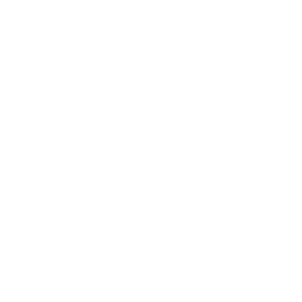

In [216]:
#アニメーション生成用

#https://scipython.com/book/chapter-8-scipy/examples/visualizing-the-spherical-harmonics/
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy.core.records import array
from scipy.special import sph_harm

def superpose(coefficients, theta, phi):
    val = 0
    for t in coefficients:
        l,m,c = t
        val += c*sph_harm(m,l,theta,phi)
    return val

fig = plt.figure(figsize=plt.figaspect(1.), facecolor='none')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

ax = fig.add_subplot(111, projection='3d', facecolor='none')
ax.set_axis_off()
ax.set_box_aspect((1,1,1)) #https://sabopy.com/py/matplotlib-3d-50/

fcolors = np.array([])
#resolution=dict(phi=100, theta=100)

def equal_area_phi(n):
    A = np.cumsum(1/np.sin(np.arange(1,n+1)*np.pi/(n+1)))
    return A * np.pi / A[-1]

def plot_spherical_harmonics(ax, coefficients, deg, elev=0.0, azim=0.0, is_first=True):
    global fcolors
    #global resolution
    phi = np.linspace(0, np.pi, 180)
    theta = np.linspace(0, 2*np.pi, 360)
    phi, theta = np.meshgrid(phi, theta)

    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)

    if(is_first):
        if(deg%4==0):
            fcolors = superpose(coefficients, theta, phi).real
        elif(deg%4==2):
            fcolors = superpose(coefficients, theta, phi).imag
        
    fmax, fmin = fcolors.max(), fcolors.min()
    #fcolors = (fcolors - fmin)/(fmax - fmin)
    norm = colors.Normalize(vmin=fmin, vmax=fmax)

    ax.view_init(elev=elev, azim=azim)
    ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=plt.cm.jet(norm(fcolors)), shade=False)
    plt.plot(1,1)

interval = 75
omega = 6
frames = 12
    
def plot(i, deg, coefficients):
    print(f"{i+1}/{frames}...")
    plot_spherical_harmonics(ax, coefficients, deg, elev=30, azim=omega*i, is_first=True if i==0 else False)

def animate(f, deg, file="out.gif"):
    v = get_normalized_coefficients(f, deg)
    coefficients = []
    for i, c in enumerate(v):
        coefficients.append((deg//2, deg//2-i, c.n()))
    ani = animation.FuncAnimation(fig, lambda i:plot(i,deg,coefficients), interval=interval, frames=frames)
    #ani.repeat()
    ani.save(file, writer="imagemagick", savefig_kwargs=dict(facecolor="black"))

In [203]:
f

X^71 + 194327*X^61 - 9577545*X^56 - 42805829*X^51 + 876828771*X^46 - 951230665*X^41 + 800021397*X^36 + 951230665*X^31 + 876828771*X^26 + 42805829*X^21 - 9577545*X^16 - 194327*X^11 - X

In [208]:
deg = 72
f = (awesome_polynomial(deg))(x/y) * y^deg
f = f.expand()

In [ ]:
interval = 150
omega = 6
frames = 12
    
animate(f, deg, file="rotating-icosahedron-deg-72-rep.gif")